# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [21]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
25Jan2007Kennedy4.txt,FOR IMMEDIATE RELEASE FACT SHEET I...
20Oct2005Kennedy14.txt,FOR IMMEDIATE RELEASE As this bil...
03Mar2007Kennedy7.txt,FOR IMMEDIATE RELEASE Ann Coulter...
10Jul2007Kennedy8.txt,FOR IMMEDIATE RELEASE Thank you all ...
20Jul2007Kennedy14.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [22]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
25Jan2007Kennedy4.txt,FOR IMMEDIATE RELEASE FACT SHEET I...,Kennedy
20Oct2005Kennedy14.txt,FOR IMMEDIATE RELEASE As this bil...,Kennedy
03Mar2007Kennedy7.txt,FOR IMMEDIATE RELEASE Ann Coulter...,Kennedy
10Jul2007Kennedy8.txt,FOR IMMEDIATE RELEASE Thank you all ...,Kennedy
20Jul2007Kennedy14.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [23]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
19Mar2007Kyl117.txt,SECURITY ON STRIKE\n The U.S. Senate recently...,Kyl
10Nov2005Kyl304.txt,SEN. KYL AMENDMENT ON HUMVEE UPGRADE PASSES SE...,Kyl
6Dec2007Kyl46.txt,SEN. KYL ELECTED ASSISTANT SENATE REPUBLICAN L...,Kyl
29Aug2005Kyl347.txt,SEN. KYL: GOOD NEWS AND BAD NEWS FOR BACK TO S...,Kyl
11Sep2006Kyl161.txt,SENATE COMMEMORATES FIVE YEAR MARK OF 9/11 ATT...,Kyl


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [24]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
19Mar2007Kyl117.txt,SECURITY ON STRIKE\n The U.S. Senate recently...,Kyl,"[[SECURITY, ON, STRIKE, The, U.S., Senate, rec...","[[security, strike, senate, recently, approved..."
10Nov2005Kyl304.txt,SEN. KYL AMENDMENT ON HUMVEE UPGRADE PASSES SE...,Kyl,"[[SEN., KYL, AMENDMENT, ON, HUMVEE, UPGRADE, P...","[[kyl, amendment, humvee, upgrade, passes, sen..."
6Dec2007Kyl46.txt,SEN. KYL ELECTED ASSISTANT SENATE REPUBLICAN L...,Kyl,"[[SEN., KYL, ELECTED, ASSISTANT, SENATE, REPUB...","[[kyl, elected, assistant, senate, republican,..."
29Aug2005Kyl347.txt,SEN. KYL: GOOD NEWS AND BAD NEWS FOR BACK TO S...,Kyl,"[[SEN., KYL, :, GOOD, NEWS, AND, BAD, NEWS, FO...","[[kyl, good, news, bad, news, back, school, st..."
11Sep2006Kyl161.txt,SENATE COMMEMORATES FIVE YEAR MARK OF 9/11 ATT...,Kyl,"[[SENATE, COMMEMORATES, FIVE, YEAR, MARK, OF, ...","[[senate, commemorates, five, year, mark, atta..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [25]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [26]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([-1.15627408e+00,  7.58639514e-01, -7.15068102e-01,  8.24473798e-01,
       -1.03685848e-01, -1.62126219e+00, -1.89291883e+00,  7.09738851e-01,
        3.78061354e-01, -8.34736347e-01, -4.59991425e-01,  6.38371527e-01,
       -1.02509654e+00,  1.28709316e+00,  1.30273366e+00, -9.51807141e-01,
        2.51745790e-01, -2.14210272e+00, -1.20495021e-01, -7.66310453e-01,
        1.37348759e+00,  2.12413120e+00,  1.11964560e+00, -3.48195821e-01,
        1.23590350e+00, -3.07787609e+00, -1.81048012e+00, -5.78642964e-01,
        1.02727458e-01,  7.89349854e-01, -5.54192007e-01, -2.29812805e-02,
       -8.22023869e-01,  8.34020853e-01, -1.04401007e-01, -2.18717003e+00,
        4.05011594e-01, -3.64446267e-02, -1.29519486e+00, -2.06349087e+00,
        2.86622620e+00, -2.32021451e-01,  2.05259895e+00,  1.01037696e-01,
       -8.31789494e-01, -1.38403678e+00,  7.31691062e-01,  1.98710060e+00,
        2.32125688e+00, -6.39449894e-01, -2.02226520e+00, -1.03116500e+00,
       -2.37646651e+00,  

If you want the full matrix, `syn0` stores all the vectors:

In [27]:
senReleasesW2V.wv.syn0

array([[-9.4120795e-01, -1.8400685e+00, -1.3218987e+00, ...,
         1.3542643e-01, -5.0177014e-01, -8.6544496e-01],
       [-9.4934297e-01,  4.3845165e-01, -9.4257241e-01, ...,
        -6.2096912e-01,  8.0198520e-01,  1.3230622e+00],
       [-2.4325869e+00, -4.9644064e-02,  4.8183766e-01, ...,
         2.3541257e+00, -1.2899616e+00,  4.7361198e-01],
       ...,
       [-1.7177382e-02, -3.1638738e-02, -1.6829874e-03, ...,
        -8.6054444e-02, -8.1356935e-02, -8.6381786e-02],
       [ 3.4426276e-02, -3.1038364e-02, -2.9358661e-02, ...,
        -6.4122252e-02, -4.8903849e-02, -4.6733070e-02],
       [ 6.4796726e-03, -2.2017041e-02, -1.2313519e-02, ...,
        -3.3690721e-02, -5.7311382e-02, -3.1229654e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [28]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [29]:
senReleasesW2V.most_similar('president')

[('administration', 0.8561171293258667),
 ('presidents', 0.7766789793968201),
 ('administrations', 0.7352709770202637),
 ('george', 0.6495853662490845),
 ('cheney', 0.6420679092407227),
 ('rollback', 0.5789810419082642),
 ('privatize', 0.5743130445480347),
 ('republican', 0.5706799030303955),
 ('veto', 0.5669924020767212),
 ('quoting', 0.5643348693847656)]

In [30]:
senReleasesW2V.most_similar('war')

[('disobedience', 0.6980276703834534),
 ('afghanistan', 0.6839396953582764),
 ('wars', 0.6707034111022949),
 ('chaos', 0.6627306938171387),
 ('unresisted', 0.654295802116394),
 ('descending', 0.648392915725708),
 ('insurgency', 0.6471118927001953),
 ('sending', 0.6431031823158264),
 ('misguided', 0.6380656957626343),
 ('bloody', 0.6377280950546265)]

Or we can get this directly (calculated slightly differently):

In [31]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [32]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.54485637]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [33]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [34]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.727771520614624),
 ('bushs', 0.7126743793487549),
 ('veto', 0.7092330455780029),
 ('signed', 0.699372410774231),
 ('vetoes', 0.6667923927307129),
 ('vetoed', 0.6663817763328552),
 ('signature', 0.6619501709938049),
 ('signing', 0.6569038033485413),
 ('presidents', 0.6391920447349548),
 ('sign', 0.6329113841056824)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [35]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.28565806,
 0.28813428,
 0.34111184,
 0.39012378,
 0.3996875,
 0.45880115,
 0.46837172,
 0.49124125,
 0.51016086,
 0.5160894,
 0.5161947,
 0.5259503,
 0.5289189,
 0.5531907,
 0.55609596,
 0.5720395,
 0.6015819,
 0.62895036]

In [36]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.28813428 0.6015819


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [43]:
senReleasesDF[sample_indices == i]

,text,category,tokenized_sents,normalized_sents
17Mar2005Kyl399.txt,SEN. KYL CRITICIZES MEXICAN PRESIDENT FOR THRE...,Kyl,"[[SEN., KYL, CRITICIZES, MEXICAN, PRESIDENT, F...","[[kyl, criticizes, mexican, president, threats..."
4Feb2008Kyl28.txt,STATE OF OUR UNION 2008\n In his final State ...,Kyl,"[[STATE, OF, OUR, UNION, 2008, In, his, final,...","[[state, union, final, state, union, address, ..."
30May2006Kyl209.txt,SECURING BORDER MUST COME FIRST\n The problem...,Kyl,"[[SECURING, BORDER, MUST, COME, FIRST, The, pr...","[[securing, border, must, come, first, problem..."
8Feb2006Kyl264.txt,SEN. KYL CONCERNED NEW BUDGET LEAVES ARIZONA'S...,Kyl,"[[SEN., KYL, CONCERNED, NEW, BUDGET, LEAVES, A...","[[kyl, concerned, new, budget, leaves, arizona..."
11Oct2004Kyl447.txt,SEN. KYL CONGRATULATES NOBEL LAUREATE\n Sen. ...,Kyl,"[[SEN., KYL, CONGRATULATES, NOBEL, LAUREATE, S...","[[kyl, congratulates, nobel, laureate, jon, ky..."
17Apr2006Kyl231.txt,PROTECTING CHILDREN\n Abuse and neglect of ou...,Kyl,"[[PROTECTING, CHILDREN, Abuse, and, neglect, o...","[[protecting, children, abuse, neglect, childr..."
18May2006Kyl214.txt,SEN. KYL: TEMPORARY MEANS TEMPORARY\n Sen. Jo...,Kyl,"[[SEN., KYL, :, TEMPORARY, MEANS, TEMPORARY, S...","[[kyl, temporary, means, temporary, jon, kyl, ..."
13Jun2006Kyl201.txt,SEN. KYL INTRODUCES LEGISLATION TO ADD LAND TO...,Kyl,"[[SEN., KYL, INTRODUCES, LEGISLATION, TO, ADD,...","[[kyl, introduces, legislation, add, land, las..."
5May2006Kyl223.txt,"SENS. KYL, FEINSTEIN CALL FOR ELIMINATING ETHA...",Kyl,"[[SENS, .], [KYL, ,, FEINSTEIN, CALL, FOR, ELI...","[[sens], [kyl, feinstein, call, eliminating, e..."
28Nov2005Kyl293.txt,SEN. KYL JOINS BUSH AT TUCSON BORDER BRIEFING\...,Kyl,"[[SEN., KYL, JOINS, BUSH, AT, TUCSON, BORDER, ...","[[kyl, joins, bush, tucson, border, briefing, ..."


In [39]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.99978143 0.99886113 0.99295092 0.99954009 0.99937177 0.99330014
 0.99497122 0.99520278 0.9994607  0.99742031]
[364. 378. 415. 393. 394. 398. 428. 359. 379. 396.]


In [44]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.7016355512422501 0.7022332148801056


We can also save the vectors for later use:

In [45]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [51]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [52]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.94120795, -1.8400685 , -1.3218987 , ...,  0.13542643,
        -0.50177014, -0.86544496],
       [-0.94934297,  0.43845165, -0.9425724 , ..., -0.6209691 ,
         0.8019852 ,  1.3230622 ],
       [-2.432587  , -0.04964406,  0.48183766, ...,  2.3541257 ,
        -1.2899616 ,  0.47361198],
       ...,
       [-0.7458146 ,  0.41669658,  0.6002132 , ..., -1.8028432 ,
        -1.1281102 , -1.7471681 ],
       [-0.32803816, -0.4299144 , -0.49309182, ...,  0.9839894 ,
         0.4961773 ,  0.03256946],
       [ 0.6929918 ,  0.07891822, -0.29634103, ..., -0.48087245,
         0.24238855,  0.4636628 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [53]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

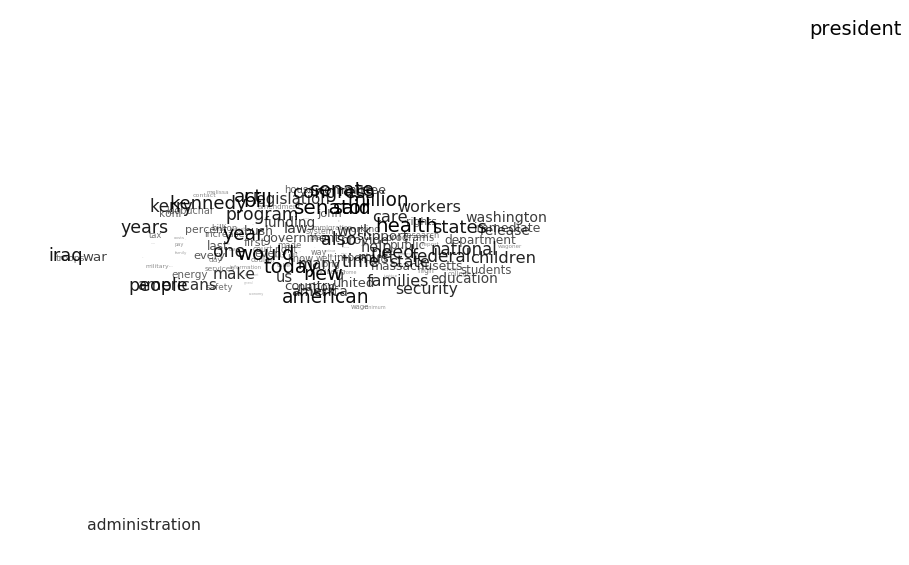

In [54]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [ ]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [ ]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [ ]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

In [ ]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [ ]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

Now we have the training loss and can optimize training to minimize it.

In [ ]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

In [ ]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [ ]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

In [ ]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [25]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [26]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [27]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [28]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [29]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [30]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [2]:
TWNewsDF = pandas.read_csv('../data/TWNews.txt', sep = "|", header = 0)
TWNewsDF[:10]

,category,date,text,title,url
0,taiwan,2017/12/31,The Ministry of Foreign Affairs yesterday dism...,Ministry denies hiding flawed passports,http://www.taipeitimes.com/News/taiwan/archive...
1,taiwan,2017/12/31,The Ministry of Foreign Affairs' swift demotio...,IN FOCUS: Diplomat's dismissal not political p...,http://www.taipeitimes.com/News/taiwan/archive...
2,taiwan,2017/12/31,Premier William Lai (') on Friday said he hope...,DPP outlines priorities for special legislativ...,http://www.taipeitimes.com/News/taiwan/archive...
3,taiwan,2017/12/31,The results of a Democratic Progressive Party ...,DPP challenges labor rules poll with its own n...,http://www.taipeitimes.com/News/taiwan/archive...
4,taiwan,2017/12/31,The Presidential Office has denied claims made...,Local firm not involved in N Korea oil transfe...,http://www.taipeitimes.com/News/taiwan/archive...
5,taiwan,2017/12/31,The Legislative Yuan on Friday passed amendmen...,Students at experimental schools gain recognition,http://www.taipeitimes.com/News/taiwan/archive...
6,taiwan,2017/12/31,Poor air quality affects not only people's lun...,Poor air quality linked to insomnia and depres...,http://www.taipeitimes.com/News/taiwan/archive...
7,taiwan,2017/12/31,The nation's development in the past was guide...,Poet warns against foreign culture,http://www.taipeitimes.com/News/taiwan/archive...
8,taiwan,2017/12/31,"As per tradition, many of the nation's compani...",FEATURE: Taiwanese firms return to desk calend...,http://www.taipeitimes.com/News/taiwan/archive...
9,taiwan,2017/12/31,A Taichung man who lost his memory has been di...,Man's sudden-onset amnesia linked to septicemi...,http://www.taipeitimes.com/News/taiwan/archive...


In [3]:
TWNewsDF['tokenized_sents'] = TWNewsDF['text'].str.replace("-","").apply(lambda x: 
                                                                         [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
TWNewsDF['normalized_sents'] = TWNewsDF['tokenized_sents'].apply(lambda x: 
                                                    [lucem_illud.normalizeTokens(s, 
                                                                                 stopwordLst = lucem_illud.stop_words_basic, 
                                                                                 stemmer = None)
                                                    for s in x])

TWNewsDF[:5]

,category,date,text,title,url,tokenized_sents,normalized_sents
0,taiwan,2017/12/31,The Ministry of Foreign Affairs yesterday dism...,Ministry denies hiding flawed passports,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, Ministry, of, Foreign, Affairs, yesterd...","[[ministry, foreign, affairs, yesterday, dismi..."
1,taiwan,2017/12/31,The Ministry of Foreign Affairs' swift demotio...,IN FOCUS: Diplomat's dismissal not political p...,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, Ministry, of, Foreign, Affairs, ', swif...","[[ministry, foreign, affairs, swift, demotion,..."
2,taiwan,2017/12/31,Premier William Lai (') on Friday said he hope...,DPP outlines priorities for special legislativ...,http://www.taipeitimes.com/News/taiwan/archive...,"[[Premier, William, Lai, (, ', ), on, Friday, ...","[[premier, william, lai, friday, said, hopes, ..."
3,taiwan,2017/12/31,The results of a Democratic Progressive Party ...,DPP challenges labor rules poll with its own n...,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, results, of, a, Democratic, Progressive...","[[results, democratic, progressive, party, dpp..."
4,taiwan,2017/12/31,The Presidential Office has denied claims made...,Local firm not involved in N Korea oil transfe...,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, Presidential, Office, has, denied, clai...","[[presidential, office, denied, claims, made, ..."


In [4]:
TWNewsW2V = gensim.models.word2vec.Word2Vec(TWNewsDF['normalized_sents'].sum())

In [5]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

print("The cosine difference between the word 'international' and the word 'local' is: {}".format(
      cos_difference(TWNewsW2V, 'international', 'local')[0,0]))
print("The cosine difference between the word 'international' and the word 'world' is: {}".format(
      cos_difference(TWNewsW2V, 'international', 'world')[0,0]))
print("The cosine difference between the word 'international' and the word 'foreign' is: {}".format(
      cos_difference(TWNewsW2V, 'foreign', 'international')[0,0]))
print("The cosine difference between the word 'china' and the word 'japan' is: {}".format(
      cos_difference(TWNewsW2V, 'china', 'japan')[0,0]))
print("The cosine difference between the word 'taiwan' and the word 'japan' is: {}".format(
      cos_difference(TWNewsW2V, 'taiwan', 'japan')[0,0]))
print("The cosine difference between the word 'taiwan' and the word 'china' is: {}".format(
      cos_difference(TWNewsW2V, 'taiwan', 'china')[0,0]))
print("The cosine difference between the word 'taiwanese' and the word 'chinese' is: {}".format(
      cos_difference(TWNewsW2V, 'taiwanese', 'chinese')[0,0]))

The cosine difference between the word 'international' and the word 'local' is: 0.11802195012569427
The cosine difference between the word 'international' and the word 'world' is: 0.6650351285934448
The cosine difference between the word 'international' and the word 'foreign' is: 0.4277587831020355
The cosine difference between the word 'china' and the word 'japan' is: 0.6806716918945312
The cosine difference between the word 'taiwan' and the word 'japan' is: 0.7098989486694336
The cosine difference between the word 'taiwan' and the word 'china' is: 0.5738372802734375
The cosine difference between the word 'taiwanese' and the word 'chinese' is: 0.6305859088897705


In [6]:
#Bootstrapping

estimatesB=[]
for x in range(20):
    TWNewsW2VB = gensim.models.word2vec.Word2Vec(TWNewsDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(TWNewsW2VB, 'local', 'international')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()

print(estimatesB)

print("The 90% confidence interval for the cosine distance between 'local' and 'international' is:\n",estimatesB[1], estimatesB[-2])

[-0.0061715962, 0.009621152, 0.019508304, 0.021093955, 0.028711695, 0.028938927, 0.074858084, 0.07914573, 0.08919867, 0.09807417, 0.101474725, 0.10671693, 0.10869583, 0.109431915, 0.11184698, 0.11457512, 0.17636772, 0.18282987, 0.1869359, 0.2104712]
The 90% confidence interval for the cosine distance between 'local' and 'international' is:
 0.009621152 0.1869359


In [19]:
TWNewsW2V.most_similar(positive=['ingwen', 'dpp'], negative = ['kmt'])

[('yiyu', 0.768915057182312),
 ('shihying', 0.7521408796310425),
 ('chichang', 0.7207480669021606),
 ('tsai', 0.6805303692817688),
 ('inauguration', 0.6635650396347046),
 ('promises', 0.6600677967071533),
 ('mingyen', 0.6568668484687805),
 ('inaugural', 0.6399880051612854),
 ('hungteh', 0.6300640106201172),
 ('standstill', 0.6295530200004578)]

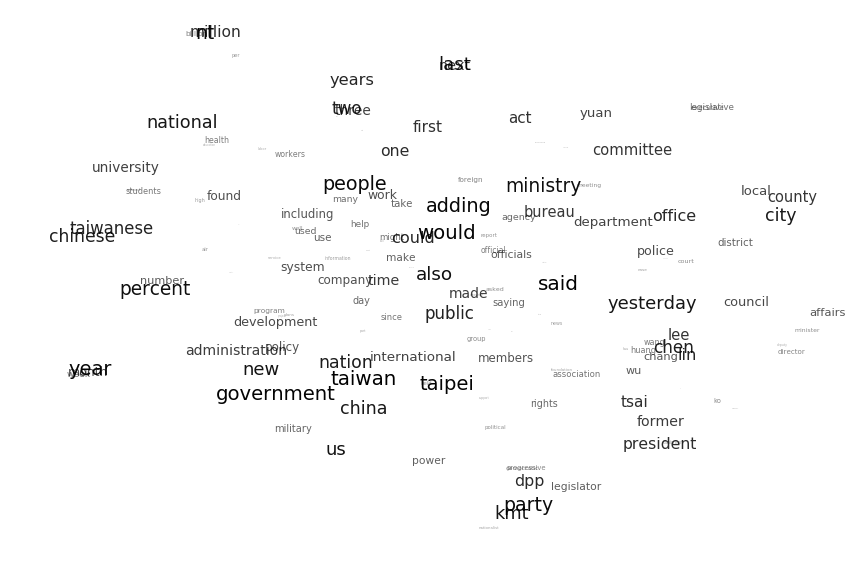

In [21]:
#subsetting words for visualization
numWords = 150
targetWords = TWNewsW2V.wv.index2word[:numWords]

#create sub-matrix for visualization
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(TWNewsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

#reduce dimension
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

#visualization!
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

## Exercise 1 Memo

The corpus used in this exercise is a full collection of Taiwan news scraped from the website 'Taipei Times' (http://www.taipeitimes.com). It consists of over 4800 news articles, which should provide enough accuracy for the deep learning method of the genism library. (Noticeably, I used a much smaller corpus in the first place, and the trained model was not very accurate.)

First of all, after the model is generated, I calculated cosine similarities between a few words to test the model accuracy. According to the result, the cosine similarity between 'local' and 'international' is around 0.0718, suggesting that these two words are not similar at all. As expected, the cosine similarity between 'international' and 'world' is much higher (around 0.6267). The cosine similarity between 'international' and 'foreign' is around 0.3738, which is a bit lower than my initial guess, but still in acceptable range. Since the results above is generally in agreement with my personal expectation, I decided to proceed with this model.

I then calculated the cosine similarity score between 'china', 'taiwan' and 'japan'. While 'japan' had similarity scores of around 0.7 with both 'china' and 'taiwan', the cosine similarity between 'china' and 'taiwan' is only 0.6. The similarity score between 'chinese' and 'taiwanese' was slightly higher (around 0.64). This result is in fact somewhat surprising, as chinese and japanese usually do not identify with each other, and there is supposed to be a stronger tie between mainland china and taiwan. The observed result might be partly caused by the increasingly strong recognition of 'taiwan identity' among taiwanese in the past several years，and the de-Sinicization (removal of Chinese influence) policy under the ruling of DPP government.

The visualization also revealed some interesting patterns. First of all, according to the result, 'dpp' (DPP/The Democratic Progressive Party) and 'kmt' (KMT/Kuomintang) are extremely similar to each other, despite the fact that they usually speak for opposite ideologies and policies. Also, despite the fact that 'chinese' is quite close to 'taiwanese', and that 'china' is close to 'taiwan' on the map, 'chinese'/'taiwanese' is very far from 'china'/'taiwan'. A possible explanation is that the algorithm tends to classify words more on what they actually are (countries, people, etc.) and less on what they actually mean. Another possible explanation is that no stemmer is used while training this model, which may futher reduce the weight of meanings of words in the algorithm (because stems are often associated with meanings).

Some other random but interesting observations include that, 'people' is very close to 'work', and 'company' stands in the middle between 'people' and 'government'. (hmmmm?) Also, the word 'legislator' is quite far from 'legislative', but is extremely close to the 'party', 'kmt', and 'dpp'. (wow!) This observation may suggests that the legislators in Taiwan are strongly influenced by the political parties and their respective ideologies/policies.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [38]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [33]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [34]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [35]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [36]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [37]:
apsD2V.docvecs[1952]

array([ 0.33696997, -1.218426  ,  0.77769536, -1.2436711 , -0.93585974,
       -0.58905894,  0.3667863 , -0.71601456,  0.9431071 ,  0.10514754,
       -1.3648063 , -0.9119069 , -0.4805054 ,  0.8016981 , -0.44475162,
        0.949897  ,  0.2750762 , -0.5098536 , -0.46942407, -1.3695889 ,
       -1.446731  , -1.3071648 ,  0.99287236, -1.4453905 , -0.12296593,
        0.58859116, -0.8730691 , -1.1333594 , -0.8404249 , -0.24546354,
        0.02848427,  0.9556961 ,  0.70622855,  0.42452294, -1.5414505 ,
       -0.72141933,  0.01567354,  0.09578741,  0.4905179 ,  0.65473074,
       -0.6174239 , -0.02434308,  0.50113857,  0.09743275,  0.01956225,
        1.6049696 , -0.50665027,  0.02387065,  0.20094429,  0.9070049 ,
        1.7402828 , -1.5141268 ,  1.4388012 ,  1.6948127 , -0.673939  ,
        1.2258341 ,  0.39029765, -1.1219523 , -0.9060592 ,  0.3599193 ,
       -0.23890494,  1.0102026 ,  0.08924157,  0.82143646, -1.0398176 ,
        1.3663259 , -0.10816079, -0.8011003 ,  0.13716705,  0.56

The words can still be accessed in the same way:

In [38]:
apsD2V['atom']

array([-0.08446857, -0.13310567,  0.76769716,  0.09199319, -0.8318273 ,
       -0.9667662 ,  0.19666474, -0.25466406,  0.10815541,  0.15054949,
       -0.16121422,  0.09450565, -0.7948625 , -0.06357443,  0.15401892,
        0.24936496,  0.0959717 ,  1.0449395 ,  0.28643677, -0.52428114,
       -0.03410733, -1.0592328 , -0.25746533, -1.0623927 , -0.27061018,
       -0.03547266,  0.39062172, -0.9111596 ,  0.02812086,  0.18007664,
        0.61605734, -0.4145628 ,  0.42855403,  0.14217614,  0.08817472,
       -0.5187094 , -0.21278135,  0.20793508,  0.2911178 , -0.727797  ,
        0.6449067 ,  0.1859763 , -0.0175694 , -0.0139199 , -0.46649638,
       -0.3748949 , -1.0712662 , -0.720538  , -0.04117895,  0.61615664,
        1.1272829 , -1.3560671 ,  0.899589  , -0.64328134, -0.24923839,
       -0.29499203, -0.4975179 , -0.59219724, -0.4151598 ,  0.12087698,
        0.1786247 ,  1.1079594 ,  0.20142445,  0.44005418,  0.29087266,
        0.6117812 ,  0.36966828, -0.77955234, -0.43765077,  0.16

We can still use the ``most_similar`` command to perform simple semantic equations:

In [42]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.771075963973999)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [43]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('superconductivity', 0.9167728424072266)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [44]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.6275522]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [45]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.100.1646', 0.6934189796447754),
 ('10.1103/PhysRev.84.457', 0.6684035062789917),
 ('10.1103/PhysRev.95.897', 0.6483315229415894),
 ('10.1103/PhysRev.92.1152', 0.6350014805793762),
 ('10.1103/PhysRev.105.1459', 0.6346756219863892)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [46]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('tenth', 0.6652909517288208),
 ('magnitude', 0.6625649929046631),
 ('relaxation', 0.6513506174087524),
 ('change', 0.6451077461242676),
 ('constant', 0.6388159990310669)]

We can even look for documents most like a query composed of multiple words:

In [47]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.113.890', 0.7850648760795593),
 ('10.1103/PhysRev.103.966', 0.7695560455322266),
 ('10.1103/PhysRev.85.1012', 0.7665467262268066),
 ('10.1103/PhysRev.101.388', 0.7606978416442871),
 ('10.1103/PhysRev.89.1165', 0.7599977850914001)]

Now let's plot some words and documents against one another with a heatmap:

In [48]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

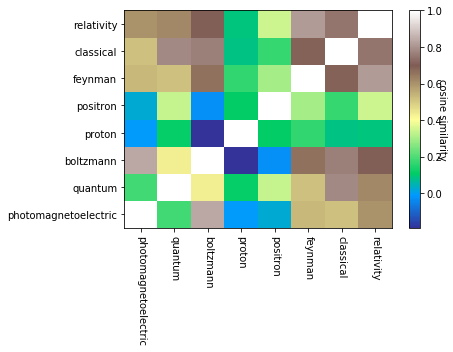

In [49]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [50]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

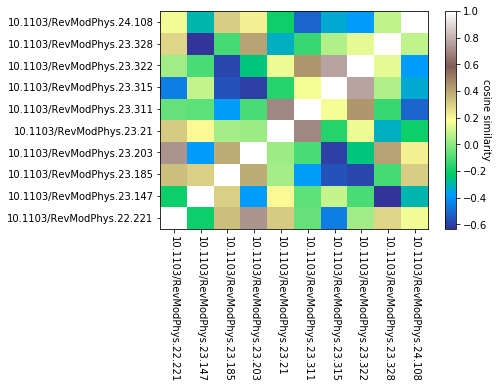

In [51]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [52]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

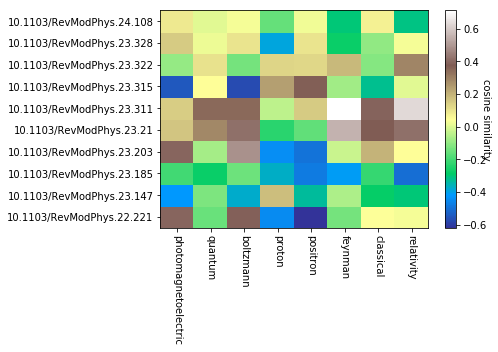

In [53]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [54]:
apsD2V.save('apsW2V')

We can later load it:

In [55]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [69]:
keywords = ['international', 'local', 'military','entertainment', 'economy', 'science','art','environment']

TWNewsDF['tokenized_words'] = TWNewsDF['text'].str.replace("-","").apply(lambda x: nltk.word_tokenize(x))
TWNewsDF['normalized_words'] = TWNewsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))


taggedDocs = []
for index, row in TWNewsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['title'])
    docKeywords.append(row['date'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
TWNewsDF['TaggedText'] = taggedDocs
TWNewsDF[:5]

,category,date,text,title,url,tokenized_sents,normalized_sents,tokenized_words,normalized_words,TaggedText
0,taiwan,2017/12/31,The Ministry of Foreign Affairs yesterday dism...,Ministry denies hiding flawed passports,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, Ministry, of, Foreign, Affairs, yesterd...","[[ministry, foreign, affairs, yesterday, dismi...","[The, Ministry, of, Foreign, Affairs, yesterda...","[ministry, foreign, affairs, yesterday, dismis...","([ministry, foreign, affairs, yesterday, dismi..."
1,taiwan,2017/12/31,The Ministry of Foreign Affairs' swift demotio...,IN FOCUS: Diplomat's dismissal not political p...,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, Ministry, of, Foreign, Affairs, ', swif...","[[ministry, foreign, affairs, swift, demotion,...","[The, Ministry, of, Foreign, Affairs, ', swift...","[ministry, foreign, affairs, swift, demotion, ...","([ministry, foreign, affairs, swift, demotion,..."
2,taiwan,2017/12/31,Premier William Lai (') on Friday said he hope...,DPP outlines priorities for special legislativ...,http://www.taipeitimes.com/News/taiwan/archive...,"[[Premier, William, Lai, (, ', ), on, Friday, ...","[[premier, william, lai, friday, said, hopes, ...","[Premier, William, Lai, (, ', ), on, Friday, s...","[premier, william, lai, friday, said, hopes, p...","([premier, william, lai, friday, said, hopes, ..."
3,taiwan,2017/12/31,The results of a Democratic Progressive Party ...,DPP challenges labor rules poll with its own n...,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, results, of, a, Democratic, Progressive...","[[results, democratic, progressive, party, dpp...","[The, results, of, a, Democratic, Progressive,...","[results, democratic, progressive, party, dpp,...","([results, democratic, progressive, party, dpp..."
4,taiwan,2017/12/31,The Presidential Office has denied claims made...,Local firm not involved in N Korea oil transfe...,http://www.taipeitimes.com/News/taiwan/archive...,"[[The, Presidential, Office, has, denied, clai...","[[presidential, office, denied, claims, made, ...","[The, Presidential, Office, has, denied, claim...","[presidential, office, denied, claims, made, s...","([presidential, office, denied, claims, made, ..."


In [70]:
#Document to vector model
TWNewsD2V = gensim.models.doc2vec.Doc2Vec(TWNewsDF['TaggedText'], size = 100)

In [71]:
TWNewsD2V.most_similar(positive = ['beijing','china'], negative = ['taipei'], topn = 10)

[('roc', 0.7955434322357178),
 ('strait', 0.7828337550163269),
 ('dominican', 0.7793713808059692),
 ('toward', 0.7659620046615601),
 ('republic', 0.7653858661651611),
 ('defend', 0.7461732625961304),
 ('observers', 0.7420657873153687),
 ('annex', 0.7412620186805725),
 ('sides', 0.7411026954650879),
 ('taiwanchina', 0.7410571575164795)]

In [72]:
sklearn.metrics.pairwise.cosine_similarity(TWNewsD2V['international'].reshape(1,-1), TWNewsD2V['national'].reshape(1,-1))

array([[0.24518444]], dtype=float32)

In [77]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = TWNewsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, TWNewsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

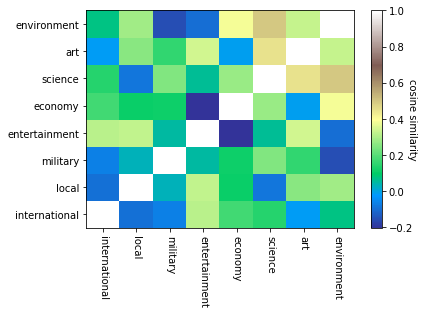

In [78]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [79]:
targetDocs = TWNewsDF['title'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = TWNewsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, TWNewsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

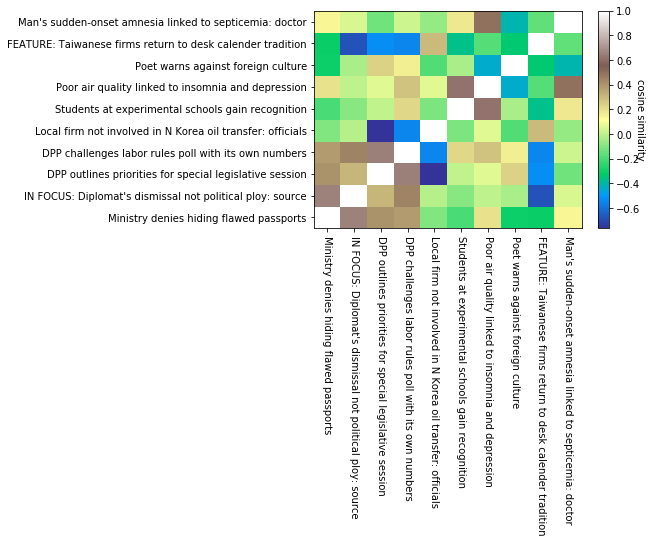

In [80]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

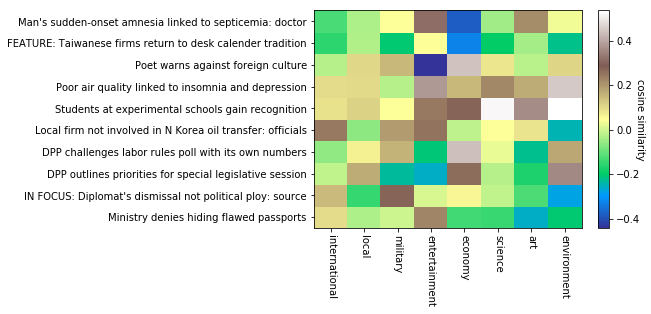

In [81]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = TWNewsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, TWNewsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [87]:
#Calculate the similarity of all documents with the keyword 'economy'

TWNewsD2V.docvecs.most_similar([TWNewsD2V['economy']],topn=len(TWNewsDF))

[('Government offers assistance loans to ASEAN projects', 0.9038494229316711),
 ("â\x80\x98New southbound policy' not affected by China: minister",
  0.890825629234314),
 ('Tourism office to open in Thailand', 0.8861500024795532),
 ('Workers prepare for life back home', 0.8805473446846008),
 ('Developers helping Vietnam, Indonesia with highway plans',
  0.8793237805366516),
 ('Tsai signals shift in approach to allies', 0.8740750551223755),
 ('Student envoys to visit Philippine, Indonesian farms', 0.8730287551879883),
 ("Nation needs to harness sun's energy, expert says", 0.8640902042388916),
 ('Executive Yuan brochure promotes southbound policy', 0.8624232411384583),
 ('Platform to aid tech exchanges with Israel: Hsu', 0.8605626821517944),
 ("Tsai briefs Asia media on â\x80\x98new southbound policy'",
  0.858839750289917),
 ('President Tsai responds to Morris Chang criticism', 0.854559600353241),
 ('Yushan Forum: Cooperation key to better future', 0.8457536101341248),
 ('Taiwan signs a

## Exercise 2 Memo

In this section, I selected a few keywords that are common in news articles to proceed with the analysis. Those selected words include 'international', 'local', 'military', 'entertainment', 'economy', 'science', 'art', and 'environment'. The document to vector model was trained on a size of 100.

According to the word-to-word heatmap, most of these keywords had similarity scores of around 0.2 with each other (green on heatmap). Noticeably, the least similar pair found was 'economy' and 'entertainment'. This is understandable, as news about 'economy' tend to be more serious and news on 'entertainment' is way less serious and can cover a wide spectrum of topics. The most similar pair of words are 'environment' and 'science'. This is in alignment with expectation, because environmental topics are often associated with use of technologies and sciences.

The first 10 documents in the corpus were used for the doc-to-doc heatmap. The topics of these news articles were relatively random, but the plot still offered some interesting insights. First of all, not so surprisingly, the two documents that directly have 'DPP' in their titles were found to have highest similarities. Overall, the documents that had high similarities (brown color) were all politics-related news. A bit surprisingly, however, the news 'Local Firm not Involved in North Korea Oil Transfer' and 'DPP outlines priorities for special legislative session' were found to have the lowest similarity score. I think these two documents were both somewhat related to politcs, and therefore expected them to be a bit more similar to each other.

According to the word-to-doc heatmap, the news 'Local Firm not Involved in North Korea Oil Transfer' was found to be similar to 'international', which is quite accurate. The modeling for some other keywords did not appear so accurate, however. For example, the news 'Man's sudden onset of amnesia linked to septicemia' was classified to be similar to 'entertainment', but not so close to 'science'. Also, a news about taiwan firms is classified to have lowest similarity with 'economy', which is very strange. The highest similarity scores in the plot were found between the document 'Students at experimental school gain recognition' and keywors 'science' and 'environment'. The document seems reasonably close to 'science' as it has both 'students', 'experiment' and 'school' in its title. However, its strong association to 'environment' is somewhat mysterious without looking closely into the document itself. My guess is that the students may be recognized for some innovation related to environmental protection.

I proceeded to select the word 'economy' and tested its similarity to each document in the corpus and sorted the documents according to their reported scores. However, because the size of the corpus is very large, I couldn't look into each document. Among the top documents that were found similar to 'economy', 'southbound policy' (a policy that aims to build a stronger economic tie with southern-Asian and eastsouthern-asian countries) and names of southern-Asian/eastsouthern-asian countries were repeatedly mentioned, suggesting that southbound policy was a key economic policy of the DPP government in year 2017.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [56]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [57]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [27]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

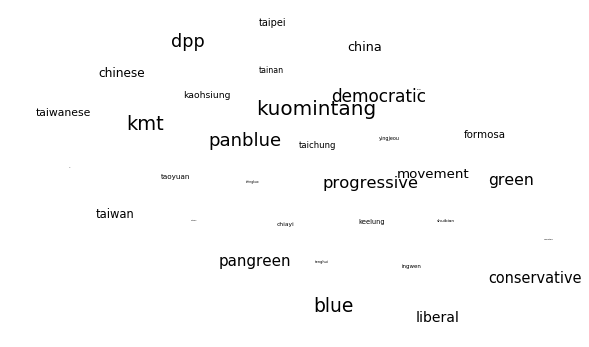

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [60]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [61]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [18]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [19]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [20]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [21]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

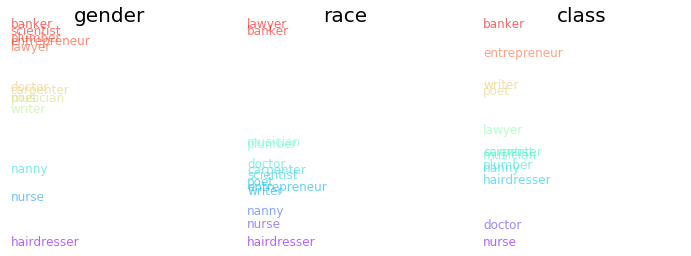

In [22]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

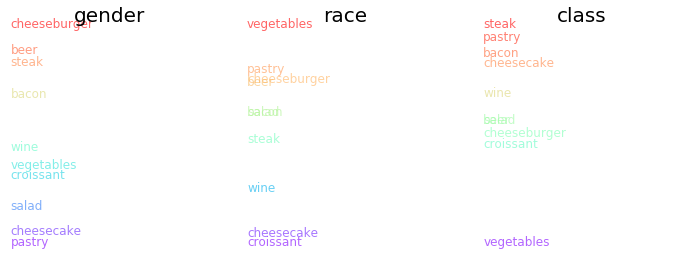

In [23]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

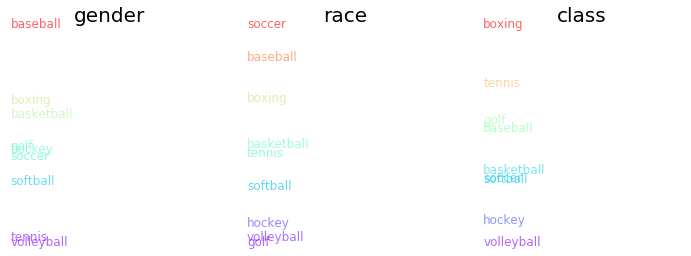

In [24]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In [7]:
#Test Model
print("\nThe words that are most similar to 'yingjeou' is:")
print(TWNewsW2V.most_similar('yingjeou'))
print("\nThe words that are most similar to 'taipei' is:")
print(TWNewsW2V.most_similar('taipei'))

def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

print("\nThe cosine similarity between 'yingjeou' and 'ingwen' is {}".
      format(cos_difference(TWNewsW2V,'yingjeou','ingwen')[0][0]))


The words that are most similar to 'yingjeou' is:
[('kuoyu', 0.9182404279708862), ('thenus', 0.9080967903137207), ('thenvice', 0.9018559455871582), ('vice', 0.9009275436401367), ('thenpresident', 0.8987864255905151), ('former', 0.8661438226699829), ('varela', 0.8650732040405273), ('obama', 0.8634388446807861), ('jintao', 0.8599045872688293), ('barack', 0.8598875403404236)]

The words that are most similar to 'taipei' is:
[('york', 0.7371457815170288), ('opening', 0.6596183776855469), ('datong', 0.6390076875686646), ('hall', 0.6243838667869568), ('tainan', 0.6205368041992188), ('mehas', 0.6168525218963623), ('closing', 0.6151455640792847), ('minh', 0.6131786108016968), ('delhi', 0.6128931641578674), ('zhongzheng', 0.6116604804992676)]

The cosine similarity between 'yingjeou' and 'ingwen' is 0.7940678000450134


In [8]:
#words to create dimensions
tnytTargetWords = ['kmt','blue','panblue','dpp','democratic','progressive','green','pangreen',
                   'conservative','liberal','movement','china', 'chinese','taiwan','taiwanese','formosa']
#words we will be mapping
tnytTargetWords += ['taipei','kaohsiung','taichung','tainan','taoyuan','keelung','chiayi',
                    'ingwen','yingjeou','shuibian','tenghui',
                    'chingkuo','yatsen','kaishek','lien']


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(TWNewsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-9.77952719e-01, -1.64062941e+00, -2.47505784e-01, ...,
        -1.68968177e+00,  4.42918539e-01, -2.32436180e+00],
       [-1.22555465e-01,  3.70602429e-01,  2.67787222e-02, ...,
        -3.42087358e-01,  2.45968640e-01,  4.07423228e-01],
       [-4.29838359e-01, -7.09411269e-03,  2.54794564e-02, ...,
        -4.92724985e-01,  1.84856296e-01, -2.63359278e-01],
       ...,
       [-8.49922180e-01,  3.42383496e-02, -1.67878568e-01, ...,
        -6.70381665e-01, -7.93088377e-02,  5.04711330e-01],
       [-8.59304249e-01,  1.65048358e-03, -5.75674735e-02, ...,
        -4.09839720e-01,  4.05392021e-01,  1.35422662e-01],
       [-4.69439030e-01,  2.62451284e-02, -1.17680244e-01, ...,
        -4.19109821e-01,  9.45215765e-03, -1.34307250e-01]], dtype=float32)

In [9]:
pcaWordsTWNews = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataTWNews = pcaWordsTWNews.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsTWNews = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataTWNews)

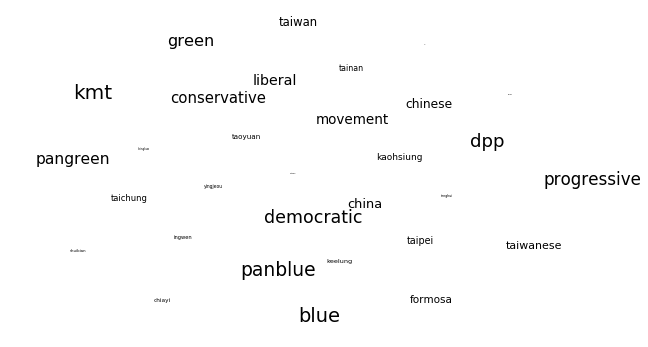

In [10]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsTWNews[:,0], tsneWordsTWNews[:,1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsTWNews[:,0][i],tsneWordsTWNews[:,1][i]), size = 20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
                #20 * (len(tnytTargetWords) - i) / len(tnytTargetWords)) instead
plt.xticks(())
plt.yticks(())
plt.show()

In [18]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [19]:
KMT_DPP_Spectrum = dimension(TWNewsW2V, ['kmt'],
                                          ['dpp'])
Conv_Lib_Spectrum = dimension(TWNewsW2V, ['conservative'],
                                        ['liberal'])
CN_TW_Spectrum = dimension(TWNewsW2V, ['china', 'chinese'],
                                     ['taiwan','taiwanese'])

In [22]:
def makeDF(model, word_list):
    bg = []
    cl = []
    ct = []
    for word in word_list:
        bg.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), KMT_DPP_Spectrum.reshape(1,-1))[0][0])
        cl.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Conv_Lib_Spectrum.reshape(1,-1))[0][0])
        ct.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), CN_TW_Spectrum.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'KMT_DPP_Spectrum': bg,
                           'Conv_Lib_Spectrum': cl,
                           'CN_TW_Spectrum':ct}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [25]:
MajorCities = ['taipei','kaohsiung','taichung','tainan','taoyuan','keelung']
MajorFigures = ['ingwen','yingjeou','shuibian','tenghui','chingkuo','yatsen','kaishek']

Citiesdf = makeDF(TWNewsW2V, MajorCities) 
Figuresdf = makeDF(TWNewsW2V, MajorFigures)
print(Citiesdf)
print(Figuresdf)

           CN_TW_Spectrum  Conv_Lib_Spectrum  KMT_DPP_Spectrum
taipei          -0.169243           0.151094          0.085981
kaohsiung       -0.074321           0.316781          0.026862
taichung        -0.040166           0.360589          0.031670
tainan          -0.075795           0.252994         -0.036997
taoyuan         -0.109011           0.429471          0.068076
keelung         -0.062951           0.470237         -0.003976
          CN_TW_Spectrum  Conv_Lib_Spectrum  KMT_DPP_Spectrum
ingwen          0.006652           0.044803         -0.246690
yingjeou        0.180426           0.056809          0.045928
shuibian        0.002440          -0.065951         -0.057482
tenghui         0.035130          -0.055595         -0.023340
chingkuo        0.132154          -0.135353          0.051513
yatsen          0.009409          -0.145832          0.106533
kaishek         0.173495          -0.194596          0.132823


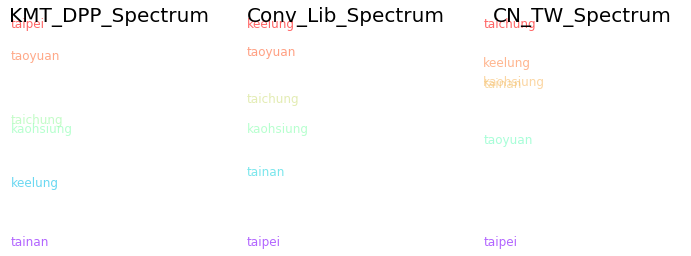

In [26]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Citiesdf, 'KMT_DPP_Spectrum')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Citiesdf, 'Conv_Lib_Spectrum')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Citiesdf, 'CN_TW_Spectrum')
plt.show()

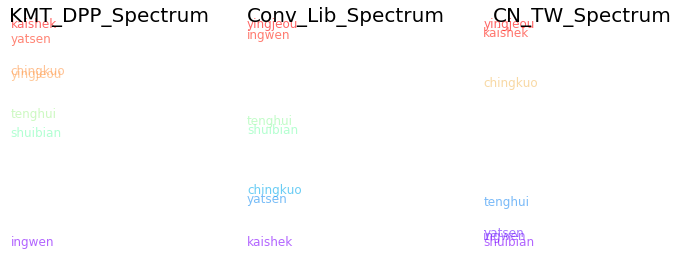

In [27]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Figuresdf, 'KMT_DPP_Spectrum')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Figuresdf, 'Conv_Lib_Spectrum')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Figuresdf, 'CN_TW_Spectrum')
plt.show()

## Exercise 3

The dimensions I chose for exercise 3 were three politics-related dimensions, namely (1) KMT_DPP_Spectrum (closeness to KMT as opposed to DPP), (2) Conv_Lib_Spectrum (conservative vs liberal), and (3) CN_TW_Spectrum (closeness to China as opposed to Taiwan). Although 'KMT' and 'DPP', or 'China' and 'Taiwan' does not neccessarily stand for opposite meanings, both pairs are often taken as somewhat contrasting words in Taiwan politics.

For the first dimension, the positive word was 'kmt' and the negative word was 'dpp'. For the second dimension, 'conservative' was chosen to be the positive word, and 'liberal' to be the negative one. For my third dimension, I chose both 'china' and 'chinese' as positive, and 'taiwan' and taiwanese' as negative.

My two lists of words to project include (1) major cities in Taiwan, and (2) past/current presidents in Taiwan. Because the political tendency of these presidents/cities are relatively clear, the projection results can then be used to test whether news documents can be used as a decent predictor for political standpoints.

According to the projection results, 'ingwen' (蔡英文, Tsai Ing-wen, the current president of Taiwan and president of DPP) was found to be the most 'DPP' political figure. This result is quite reasonable considering her role of current president of DPP. Similar to my expectation, 'kaishek'（蒋介石, Chiang Kai-shek） and 'yatsen'(孙中山, Sun Yat-sen) were on the opposite side of the spectrum, and where the closest to KMT. This result is reasonable because Sun Yat-sen was the founder of KMT, and Chiang Kai-shek was probably the most influencial president in histroy of KMT and Republic of China. Noticeably, 'tenghui' (李登辉, Lee Teng-hui) and 'shuibian' (陈水扁, Chen Shui-bian) were very close to each other, and were found in the middle of the spectrum. The fact that Lee Teng-hui is much closer to DPP as compared to other KMT presidents is a good suggestion of the accuracy of the model, because Lee Tung-hui had a close relationship to Chen Shui-bian and to DPP as a whole despite his role of KMT president back at that time. Overall, the projection of political figures onto the KMT-DPP dimension seems quite accurate.

The projection results onto Conv_Lib_Spectrum offers some quite intereting insights. Although Tsai Ing-wen won the 2016 presidential election largely due to her 'pro-reform' political standpoint, she ('ingwen') was actually found on the far conservative side of the Conv_Lib spectrum, along with 'yingjeou' (马英九, Ma Ying-jeou), who was notorious for his conservative style of running the government. Also, the fact that 'kaishek' (Chiang Kai-shek) was projected to be the most 'liberal' president was quite opposite to common beliefs, as Chiang Kai-shek was often criticized by DPP for his authoritative ruling.

Among the major cities, Taipei was projected to be the most 'KMT' city, and Tainan the most 'DPP' city, which is relatively accurate, despite Taipei's recent shifting favor toward non-partisan candidates. However, Kaohsiung is projected to the middle of the spectrum despite the fact that this city is commonly perceived as a 'pro-DPP' city. Taipei was also found to be the most liberal city, while keelung was found to be the most conservative one.

From the assessment above, I think the news documents did a decent job predicting the political tendencies of these cities nad political figures, despite several mismatches between the projection results and common perceptions/beliefs. The model accuracy may be further improved if we perform some sampling over the selected data, or adjust parameters of the model.